## Проектная работа Тишковца М.А.
Задание: на основе датасета по игре *Quiz Freeze* получить ответы на следующие вопросы:
1. Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?
2. Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь?
3. Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок?

Выполнять задание необходимо на основе данных пользователей, которые зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно).

##### 1. Предварительные мероприятия
**1.1. Импорты и общие переменные**
<!-- Т.к. текст с заголовками выглядит слишком "размашисто" (даже с учетом понижения их до 4 уровня), 
чтобы не лезть в глубины настроек Юпитера, решаю подзаголовки (по-хорошему, как раз они уровень 4/3) оформлять просто через **-->

In [1]:
# 0. Импорты
import pandas as pd
import numpy as np
import pathlib as pth
from datetime import datetime
from IPython.core.display import HTML   #, display

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import seaborn.objects as so
%matplotlib inline

# 1. Файлы
data_dir = pth.Path(r'c:\DATA\DOC\_Personal\учеба\GITHUB\sf_44\sf_44\data')
events_file = data_dir/r'7_4_Events.csv'
purchase_file = data_dir/r'7_4_Purchase.csv'

# 1.1.2. Последовательности
levels_arranged = ('easy', 'medium', 'hard')
events_arranged = ('registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase')
tutorial_arranged = ('not started', 'not finished', 'finished')

**1.2. Функции общего назначения**

In [2]:
# 1. Краткое описание датафрейма в удобной мне форме
def df_describe(df):
    return pd.DataFrame\
    ({  'dtype':        df.dtypes
        , 'distinct':   df.nunique()
        , 'empty':      df.isna().sum()
    })

# 2. "Сплющивание" многоуровневых столбцов
def df_flatten_headers (df):
    df.columns = \
        [':'.join([x for x in col]) 
        for col in df.columns.to_flat_index()
        ]
    return df

# 3. Представление timedelta в компактном читаемом виде
# Функция немного не доведена до более-менее универсального вида и пока приводит только к одному формату под данное задание
def make_timedelta_readable (td):
    days_str = f"{td.days} days" if td.days > 0 else None
    hours = int(td.seconds/3600)
    hours_str = f"{hours} h" if hours > 0 else None    
    minutes = int ((td.seconds - hours*3600)/60)
    minutes_str = f"{minutes} min"
    return " ".join([x for x in [days_str, hours_str, minutes_str] if x is not None])

# 4. Показ датафреймов бок о бок 
# честнотянуто отсюда: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
# вношу небольшую модификацию от себя, чтобы можно было принимать стайлеры

def display_side_by_side(tables:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    stylers = [table.style if isinstance (table, pd.core.frame.DataFrame) else table 
               for table in tables]
    output = ""
    for (caption, styler) in zip(captions, stylers):
        output += styler.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

##### 2. Подготовка и изучение данных
**2.1. Читаем исходные файлы**

In [3]:
# 1. Основной лог
events_df = pd.read_csv ( events_file,
     dtype = {'id': 'Int64', 'tutorial_id': 'Int64', 'user_id': 'Int64'}
    )
events_df['start_time'] = pd.to_datetime \
        (   events_df['start_time'],
            format='%Y-%m-%dT%H:%M:%S', errors='coerce'
        )

# 2. Файл про покупки
purchase_df = pd.read_csv ( purchase_file,
     dtype =  {'id': 'Int64', 'user_id': 'Int64','amount': 'float64'}
    )
purchase_df['event_datetime'] = pd.to_datetime \
        (   purchase_df['event_datetime'],
            format='%Y-%m-%dT%H:%M:%S', errors='coerce'
        )

**2.2. Рассмотрим "формальные" параметры данных**

In [4]:
struc_dfs = \
[   df_describe (events_df)
    , df_describe (purchase_df)
    , pd.DataFrame({'value': purchase_df['amount'].describe()})
        .style.format('{:.2f}')
    # , pd.DataFrame({'value': events_df['start_time'].describe()})
    #     .style.format('{:.2f}')
]

struc_labels = [ f"Структура: {x}" for x in [ 'events_df', 'purchase_df', 'суммы заказов'] ]    # , 'таймстампы'

display_side_by_side (struc_dfs, struc_labels)

,dtype,distinct,empty
id,Int64,252334,0
event_type,object,5,0
selected_level,object,3,221248
start_time,datetime64[ns],251435,133
tutorial_id,Int64,68566,127231
user_id,Int64,74908,0
,dtype,distinct,empty
id,Int64,5956,0
user_id,Int64,5956,0
event_datetime,datetime64[ns],5955,0


**events_df**
1. Пропуски в столбцах selected_level, tutorial_id, что логично, т.к. не все пользователи выбирали уровень и проходили обучение
2. Пропуск в столбце start_time: в исходных данных были некорректные (2017.02.29), либо запорченные (20162015-09-18) даты. Решаю пропустить такие даты, не пытаясь интерпретировать
3. Столбцы selected_level, event_type будут приведены к категориальному формату после соединения датафреймов
будет добавлена категория "purchase")
5. Уникальных таймстампов немного меньше, чем id событий (даже с учетом пропусков)

**purchase_df**
1. Пропусков нет
2. id покупок столько же, сколько пользователей

**Сумма покупки**
1. Поле **purchase_df['**amount**']** выглядит как обычная сумма покупки, аномалий не прослеживается
(минимум 25, максимум 350, среднее 109, медиана 100)

**2.3. Формируем "базовую" рабочую таблицу**


In [145]:
# 1. Формируем выборку пользователей по условию задания
filtering_sample = ( events_df
    .query (f"event_type=='registration' & start_time.dt.year==2018")
    ['user_id'].unique ()
)

# 2 Фильтруем датафреймы и приводим их в вид, подходящий для объединения
events_df_filtered = ( events_df
    .query (f"user_id in @filtering_sample")
    .rename (columns={'id': 'event_id'})
)

purchase_df_filtered = ( purchase_df
    .query (f"user_id in @filtering_sample")
    .rename (columns={'id': 'purchase_id', 'event_datetime': 'start_time'})
    .assign (**{'event_type': 'purchase'})
)

# 3 Соединяем. Получаем исходный рабочий датафрейм
events_combined = \
(   pd.concat( [events_df_filtered, purchase_df_filtered], sort=False )
    .reset_index (drop=True)
    .sort_values (by='start_time')
    .astype
    ({  'selected_level':   pd.api.types.CategoricalDtype(categories=levels_arranged, ordered=True)
        , 'event_type':     pd.api.types.CategoricalDtype(categories=events_arranged, ordered=True)
    })
)

# 4. Рассмотрим распределение событий в полученной выборке
events_combined.groupby('event_type', as_index=False)['user_id'].nunique()

,event_type,user_id
0,registration,19926
1,tutorial_start,11858
2,tutorial_finish,10250
3,level_choice,8342
4,pack_choice,5737
5,purchase,1600


**2.4. Исследуем частотность событий** 

(распределение событий в жизненном цикле пользователя)

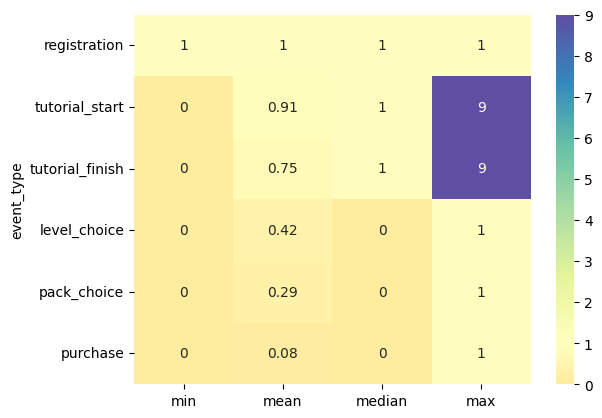

In [142]:
# 1. Посчитаем количество событий каждого вида в жизни пользователя
event_times_per_user = (events_combined.pivot_table
    (   index = 'user_id', columns = 'event_type'
        , values = 'start_time', aggfunc = 'count'
    ))
# 2. Теперь рассмотрим результаты
event_times_per_user_summary = ( event_times_per_user
    .describe().transpose()
    [['min', 'mean', '50%', 'max']].rename(columns={'50%': 'median'})
)
sns.heatmap\
(   event_times_per_user_summary, annot=True
    , cmap='Spectral', center=1
);

*Распределение событий в жизни пользователя*

В таблице выше рассматривается частотность событий каждого типа в жизни пользователя
1. Регистрация по определению происходит строго 1 раз. 
2. Все остальные события - могут не происходить (min == 0), т.е. часть пользователей, зарегистрировавшись, так и не притрагивается к игре
3. Часть пользователей проходит обучение несколько раз (максимум по tutorial_start и tutorial_finish достигает 9)
4. Тем не менее, число таких пользователей невелико, медиана у обоих событий - 1, среднее - еще меньше
5. Следующие события (**level_choice, pack_choice, purchase**) встречаются в "жизни" пользователя, дошедшего до них, ровно 1 раз (max == 1). Такая **одноразовость** выглядит странно. **Это особенность конкретной выборки или так задумано?**
6. Среднее с каждым следующим событием сокращается, что согласуется с подсчетом пользователей в п.2.3, и со здравым смыслом - после каждого события отсеивается определенный процент пользователей.

**2.5. Сравним статистику по началам и завершениям обучений**

In [146]:
start_column = event_times_per_user['tutorial_start'].value_counts()
finish_column = event_times_per_user['tutorial_finish'].value_counts()

tutorials_per_user = pd.DataFrame \
    ({  'start': start_column
        , 'finish': finish_column
        , 'start, %': (start_column / start_column.sum()).round(3)*100
        , 'finish, %': (finish_column / finish_column.sum()).round(3)*100
    })
tutorials_per_user.index.rename('times', inplace=True)
display (tutorials_per_user)

,start,finish,"start, %","finish, %"
times,,,,
0,8068,9676,40.5,48.6
1,9103,8015,45.7,40.2
2,1589,1321,8.0,6.6
3,427,345,2.1,1.7
4,221,178,1.1,0.9
5,109,117,0.5,0.6
6,116,101,0.6,0.5
7,94,97,0.5,0.5
8,86,54,0.4,0.3


1. times - количество раз
2. start и finish - количества пользователей, соответственно, начинавших и заканчивавших обучение
3. Т.е. не начинали обучение (times == 0) 8068 пользователей или 40.5% процента от общего числа
4. Таким образом по началам обучения картина такая: 40% не начинали, 46% начинали 1 раз, 8% начинали 2 раза
5. По окончаниям - похоже, но смещено в сторону "основания": 49% не закончили, 40% закончили 1 раз, 6.6% закончили 2 раза
6. Далее - по обоим параметрам идут статистически малозначительные проценты (заметные тем не менее в абсолютных цифрах - десятки и сотни людей)

##### 3. Основной анализ
Ответы на поставленные вопросы довольно удобно представлять как соотношения различных признаков пользователей.
Для этого данные удобно представить в виде "широкой" таблицы, где каждая запись представляет отдельного пользователя.

Рассмотрим "формализованные задачи" из задания

>**Вопрос 1.** Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

Понадобятся признаки:

а) Статус обучения. Таких статусов 3: 1. Завершившие обучение, 2. Не начинавшие обучение, 3) (*в задании не указано*) Начавшие, но не закончившие

б) Время прохождения этапов. Определяем так:
* События упорядочены в шкалу (Регистрация -> Начало обучения ... -> Покупка). 
* Этап - интервал между соседними событиями в шкале, называется по конечному событию (этап "Покупка" - от выбора "пакета" до собственно покупки)
* Для событий, повторяющихся неоднократно в "жизни" пользователя, за начало этапа берется дата первого появления.
* Если начальное событие этапа пропущено - интервал считается от ближайшего доступного: например, для пользователей, приступивших к выбору уровня, не закончив обучение, берется интервал между выбором уровня и *началом* обучения

>**Вопрос 2**. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

Количества начатых / законченных обучений - количества соответствующих событий

>**Вопрос 3**. 3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности.

"Булевый" признак - позже ли последнее обучечние, чем [первый] выбор сложности

**3.1. Вспомогательные функции для заполнения основной таблицы**

In [8]:
# 1. Время прохождения этапов:
def get_event_gap (df):
    last_event_at_moment = \
    (   df['first'].fillna(pd.to_datetime(0))
        .groupby(['user_id']).cummax()
    )
    previous_event = \
    (   last_event_at_moment.groupby(['user_id'])
        .shift(1)
    )
    gap = df['first'] - previous_event
    return gap

# 2. Классификация пользователей по статусу обучения
def get_tutorial_status (df):
    status_array = np.select\
    (   condlist =      [df['count:tutorial_start']==0, df['count:tutorial_finish'] > 0]
        , choicelist =  ['not started', 'finished']
        , default =     'not finished'        
    )
    result = \
    (   pd.Series(data=status_array, index = df.index.unique())
        .astype (pd.api.types.CategoricalDtype(categories=tutorial_arranged, ordered=True))
    )
    return result


# 3. Максимальный этап, до которого дошел пользователь
# -- (этот признак не пригодился, оставляю для истории) -- 
max_event_per_user = \
(events_combined
    .groupby (['user_id'],as_index=False)
    ['event_type'].max()
    .rename (columns={'event_type':'last_event'})
)

**3.2. Создаем общую таблицу**

In [163]:
user_events_wide = \
(events_combined
    .groupby (['user_id', 'event_type'],).agg
    (   count =     pd.NamedAgg (column='start_time', aggfunc='count')
        , first =   pd.NamedAgg (column='start_time', aggfunc='min')
        , last =    pd.NamedAgg (column='start_time', aggfunc='max')
    )
    .reset_index(1).assign
    (**{'gap': lambda df: get_event_gap (df)
    })
    .set_index (['event_type'], append=True).unstack(level=1)
    .pipe (df_flatten_headers)
    .assign
    (**{'tutorial_status':          lambda df: get_tutorial_status (df)
        , 'tutorial_after_level':   lambda df: df['last:tutorial_start'] > df['first:level_choice']
    })
)

# user_events_wide.shape
user_events_wide.head (10)

,count:registration,count:tutorial_start,count:tutorial_finish,count:level_choice,count:pack_choice,count:purchase,first:registration,first:tutorial_start,first:tutorial_finish,first:level_choice,...,last:pack_choice,last:purchase,gap:registration,gap:tutorial_start,gap:tutorial_finish,gap:level_choice,gap:pack_choice,gap:purchase,tutorial_status,tutorial_after_level
user_id,,,,,,,,,,,,,,,,,,,,,
27832,1,0,0,0,0,0,2018-01-01 03:48:40,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,not started,False
27833,1,1,1,0,0,0,2018-01-01 04:07:25,2018-01-01 17:47:40,2018-01-01 17:50:08,NaT,...,NaT,NaT,NaT,0 days 13:40:15,0 days 00:02:28,NaT,NaT,NaT,finished,False
27834,1,1,1,0,0,0,2018-01-01 08:35:10,2018-01-01 19:46:11,2018-01-01 19:48:01,NaT,...,NaT,NaT,NaT,0 days 11:11:01,0 days 00:01:50,NaT,NaT,NaT,finished,False
27835,1,1,1,1,1,0,2018-01-01 11:54:47,2018-01-01 15:00:51,2018-01-01 15:06:15,2018-01-01 20:37:22,...,2018-01-01 20:38:43,NaT,NaT,0 days 03:06:04,0 days 00:05:24,0 days 05:31:07,0 days 00:01:21,NaT,finished,False
27836,1,2,1,0,0,0,2018-01-01 13:28:07,2018-01-01 14:54:40,2018-01-01 15:42:58,NaT,...,NaT,NaT,NaT,0 days 01:26:33,0 days 00:48:18,NaT,NaT,NaT,finished,False
27837,1,0,0,0,0,0,2018-01-01 14:08:40,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,not started,False
27838,1,0,0,0,0,0,2018-01-01 14:42:58,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,not started,False
27839,1,1,1,1,1,0,2018-01-01 18:24:01,2018-01-01 19:11:36,2018-01-01 19:16:32,2018-01-01 22:37:50,...,2018-01-01 22:42:54,NaT,NaT,0 days 00:47:35,0 days 00:04:56,0 days 03:21:18,0 days 00:05:04,NaT,finished,False
27840,1,1,0,1,0,0,2018-01-01 20:53:21,2018-01-02 02:07:07,NaT,2018-01-02 05:18:42,...,NaT,NaT,NaT,0 days 05:13:46,NaT,0 days 03:11:35,NaT,NaT,not finished,False


In [10]:
# Наброски ответов на вопросы
# Вопрос 1. Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?
task_01 = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status']
        , values = [col for col in user_events_wide.columns if 'gap' in col]
        # , columns = ['event_type']
        , aggfunc = 'mean'
        , sort = False
    )
)
task_01

,gap:tutorial_start,gap:tutorial_finish,gap:level_choice,gap:pack_choice,gap:purchase
tutorial_status,,,,,
not started,NaT,NaT,0 days 05:15:33.122448979,0 days 00:05:23.824324324,4 days 04:49:33.590909090
not finished,0 days 05:25:02.892412935,NaT,0 days 02:47:28.088829071,0 days 00:05:05.295687885,3 days 21:14:46.908396946
finished,0 days 04:31:04.938146341,0 days 00:12:13.823121951,0 days 02:19:46.959472070,0 days 00:05:18.146058732,3 days 17:17:59.641326883


In [11]:
task_01_alt = \
(   user_events_wide
    .set_index ('tutorial_status')
    .filter (like='gap')
    .melt(ignore_index=False, var_name='event', value_name='interval')
    .assign
    (**{'event': lambda df: 
            df['event']
            .str.split(':')
            .map(lambda x:x[1])
            .astype(pd.api.types.CategoricalDtype(categories=events_arranged, ordered=True))
    })
    .groupby (['tutorial_status', 'event']).mean()
    .reset_index()
    .assign
    (**{'interval_hours': lambda df: 
                df['interval'].map(lambda x: x.days*24 + x.seconds/3600).round(3)
        , 'percent_to_max': lambda df:
                (df['interval_hours'] / df.groupby('event')['interval_hours'].transform(max)).round(3)*100
    })
    # .dropna()
)
task_01_alt

,tutorial_status,event,interval,interval_hours,percent_to_max
0,not started,registration,NaT,NaN,NaN
1,not started,tutorial_start,NaT,NaN,NaN
2,not started,tutorial_finish,NaT,NaN,NaN
3,not started,level_choice,0 days 05:15:33.122448979,5.259,100.0
4,not started,pack_choice,0 days 00:05:23.824324324,0.090,100.0
5,not started,purchase,4 days 04:49:33.590909090,100.826,100.0
6,not finished,registration,NaT,NaN,NaN
7,not finished,tutorial_start,0 days 05:25:02.892412935,5.417,100.0
8,not finished,tutorial_finish,NaT,NaN,NaN
9,not finished,level_choice,0 days 02:47:28.088829071,2.791,53.1


In [12]:
sns_so = \
(   so.Plot
    (   data = task_01_alt
        , y = 'tutorial_status'
        , x = 'percent_to_max'
        , color = 'tutorial_status'
        , text = 'interval_readable'
    )
    .facet (col='event')        #, wrap=3
    .label (x = None, y=None, color=None, title = str.capitalize)
    # .theme({**style.library["seaborn-v0_8"]})
    .add ( so.Bar () )
    .add ( so.Text (color='w', halign='right') )
    .on(fig)
)
sns_so.plot(pyplot=False)
fig.legends.pop(0);

0                NaT
1                NaT
2                NaT
3    0 days 05:00:00
4    0 days 00:00:00
5    4 days 04:00:00
6                NaT
7    0 days 05:00:00
8                NaT
9    0 days 02:00:00
10   0 days 00:00:00
11   3 days 21:00:00
12               NaT
13   0 days 04:00:00
14   0 days 00:00:00
15   0 days 02:00:00
16   0 days 00:00:00
17   3 days 17:00:00
Name: interval, dtype: timedelta64[ns]

In [13]:
sns_so = \
(   so.Plot
    (   data = task_01_alt
        , y = 'tutorial_status'
        , x = 'percent_to_max'
        , color = 'tutorial_status'
        , text = 'interval_readable'
    )
    # .layout (size=(10,3))
    # .layout (size=(15,2))
    .facet (col='event')        #, wrap=3
    .label (x = None, y=None, color=None, title = str.capitalize)
    # .theme({**style.library["seaborn-v0_8"]})
    .add ( so.Bar () )
    .add ( so.Text (color='w', halign='right') )
    .on(fig)
)
sns_so.plot(pyplot=False)
fig.legends.pop(0);

In [23]:
# Вопрос 2. Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь
purchase_rate = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status', 'count:tutorial_start']
        , values = 'count:registration'
        , columns = 'count:purchase'
        , aggfunc = 'count'
        , sort = True
        , observed=True
    )
    .assign
    (**{'purchase_rate': lambda df: df[1]/(df[0]+df[1])*100
    })
    .rename (columns = {0: 'not purchased', 1: 'purchased'})
)
purchase_rate

count:purchase                        not purchased  purchased  purchase_rate
tutorial_status count:tutorial_start                                         
not started     0                            8046.0       22.0       0.272682
not finished    1                            1431.0      124.0       7.974277
                2                              44.0        7.0      13.725490
                3                               2.0        NaN            NaN
finished        1                            6465.0     1083.0      14.348172
                2                            1327.0      211.0      13.719116
                3                             374.0       51.0      12.000000
                4                             191.0       30.0      13.574661
                5                              93.0       16.0      14.678899
                6                             102.0       14.0      12.068966
                7                              82.0       12.0      12.765957
                8                              73.0       13.0      15.116279
                9                              96.0       17.0      15.044248

In [24]:
# Вопрос 3. Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок?
tut_after_level_df = \
(user_events_wide
    .pivot_table
    (   index = ['tutorial_status']
        , columns = ['tutorial_after_level']
        , values = 'count:registration'
        , aggfunc = 'count'
    )    .assign
    (**{'rate': lambda df: df[True]/(df[True]+df[False])*100
    })
    .rename (columns = {False: 'no tutorial', True: 'started tutorial'})
)
tut_after_level_df

tutorial_after_level,no tutorial,started tutorial,rate
tutorial_status,,,
not started,8068,0,0.000000
not finished,1590,18,1.119403
finished,8882,1368,13.346341


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure (figsize=(8,4))
axes = fig.add_axes ([0,0,1,1])
axes.bar\
(   y = 
    
)

SyntaxError: invalid syntax (3746871378.py, line 9)